# Task 1: Fraud Detection

## Libraries Used

In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pip install gensim
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

## Problem Description

The goal of this task is to build a model that predicts whether a given transaction is fraudulent or not using the given features. Those features include the transaction amount, the age of the account, and whether there has been a change in location for the transaction. The constraints of this problem are that the model implemented must be either a Naive Bayes or a Gaussian Discriminant Analysis model.

In developing the final model, the typical steps of the ML pipeline will be followed. This includes data preprocessing, model selection, model evaluation, and interpretation. The data preprocessing will involve the normalization of the data, the splitting of the data into training and testing sets, and the encoding of the categorical data. The model selection will involve the selection of the best model to use for the given data. The model evaluation will involve the evaluation of the model using several metrics. Finally, the interpretation will involve the interpretation of the task results and the model to analyse the most important features, potential biases, and the model's performance.

## Data Collection

The data for this task is provided in the file `fraud_detection.xls`. It contains these columns:

- `Transaction_Amount`: The amount of the transaction (float).
- `Transaction_Time`: The time of the transaction (int).
- `Account_Age`: The age of the account (float).
- `Previous_Location`: The last known location of the account (string).
- `New_Location`: The location of the transaction (string).
- `Location_Change`: Whether there has been a change in location for the transaction (binary).
- `Is_Fraud`: Whether the transaction is fraudulent (binary).

The data will be loaded into a pandas DataFrame for further processing. Even though the file extension is `.xls`, the data is actually in the CSV format, and the `read_csv` function will be used to load the data.

In [324]:
primary_data = pd.read_csv('fraud_detection.xls')

In [325]:
primary_data.head()

,Transaction_Amount,Transaction_Time,Account_Age,Previous_Location,New_Location,Location_Change,Is_Fraud
0,67.640523,12,4.289545,New York,Houston,1,0.0
1,54.001572,16,69.876618,Chicago,Phoenix,1,0.0
2,59.787380,20,71.008455,San Diego,Los Angeles,1,0.0
3,72.408932,1,91.646912,Dallas,Philadelphia,1,0.0
4,68.675580,11,16.800002,Dallas,Houston,1,0.0


In [326]:
primary_data.describe()

,Transaction_Amount,Transaction_Time,Account_Age,Location_Change,Is_Fraud
count,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,52.882320,11.50600,98.889524,0.898400,0.020000
std,24.790510,6.89476,98.874065,0.302137,0.140007
min,12.598994,0.00000,1.000000,0.000000,0.000000
25%,43.249929,5.00000,27.243593,1.000000,0.000000
50%,49.967298,12.00000,68.808923,1.000000,0.000000
75%,56.903145,18.00000,137.471600,1.000000,0.000000
max,343.260177,23.00000,920.766040,1.000000,1.000000


An initial look suggests that the `Location_Change` column is very unbalanced with the mean > standard deviation. Additionally, the lower and upper quartiles and the median are equal. The `Is_Fraud` column also appears unbalanced with all relevant quartiles and the minimum equal to each other, equal to 0, with the max being 1. The mean is also very close to 0.

This would suggest the need for outlier handling in later stages.

In [327]:
primary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Transaction_Amount  10000 non-null  float64
 1   Transaction_Time    10000 non-null  int64  
 2   Account_Age         10000 non-null  float64
 3   Previous_Location   10000 non-null  object 
 4   New_Location        10000 non-null  object 
 5   Location_Change     10000 non-null  int64  
 6   Is_Fraud            10000 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 547.0+ KB


There are 10,000 rows in the dataframe, with three columns with float values, two integer columns, and 2 object columns. This is not entirelt accurate as the `Is_Fraud` column has binary values (0 and 1), but they are stored as float values (0.0 and 1.0).

## Data Preprocessing

This section will:
- Handle missing values in any of the columns (unlikely as the initial data exploration showed no indication of null values).
- Handle outliers.
- Scaling of numericaal features.
- Encoding of categorical variables.

### Imputing Missing Values

There is no reason to impute missing values if there are no missing values, and so the first step is checking if there are any missing values.

In [328]:
primary_data.isnull().sum()

Transaction_Amount    0
Transaction_Time      0
Account_Age           0
Previous_Location     0
New_Location          0
Location_Change       0
Is_Fraud              0
dtype: int64

There are no null values in the dataframe so no further operations are carried out for this section.

### Handling Outliers

An idea that occurred to me was to handle any outlier values as they could impact the performance of the model by making it biased to certain extreme values. The approach would have been to drop rows containing outliers. However, in subsequent steps, I realised that dropping rows resulted in many of the rows that mapped to a fraudulent transaction being dropped, and so this step is skipped completely.

In [329]:
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f'Number of outliers in {column}: {len(outliers)}')
    if len(outliers) > 0:
        print(f'Dropping outliers in {column}')
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

*note:* no longer relevant

In [330]:

# numerical_columns = ['Transaction_Amount', 'Transaction_Time', 'Account_Age']
# for column in numerical_columns:
#     primary_data = handle_outliers(primary_data, column)

In [331]:
primary_data.describe()

,Transaction_Amount,Transaction_Time,Account_Age,Location_Change,Is_Fraud
count,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,52.882320,11.50600,98.889524,0.898400,0.020000
std,24.790510,6.89476,98.874065,0.302137,0.140007
min,12.598994,0.00000,1.000000,0.000000,0.000000
25%,43.249929,5.00000,27.243593,1.000000,0.000000
50%,49.967298,12.00000,68.808923,1.000000,0.000000
75%,56.903145,18.00000,137.471600,1.000000,0.000000
max,343.260177,23.00000,920.766040,1.000000,1.000000


### Scaling of Numerical Features

To determine what scaling method should be used, i.e., normalisation or standardisation, the distribution of each column must be checked, and the appropriate method used. 

To check the distribution, the skew method is being used. If the skew of a column is < 0.5, it suggests that the column is normally distributed, and so should be standardised, which is an appropriate method for normal distributions as it maintains the relationships between observations in terms of the mean and standard deviation.

If the skew of a column is greater than 0.5, it suggests that it is not normally distributed, and so normalisation is applied to the column, to ensure that the variances and patterns in the data are maintained even as the scale is reducing.

Using skewness as a measure of normality might not be pperfect but is an intuitive appraoch as an ideal normal distribution has a skewness of 0.

In [332]:
primary_data.dtypes

Transaction_Amount    float64
Transaction_Time        int64
Account_Age           float64
Previous_Location      object
New_Location           object
Location_Change         int64
Is_Fraud              float64
dtype: object

As already highlighted, the column `Is_Fraud` should contain integral values, not float values, and so the column is cast.

In [333]:
primary_data['Is_Fraud'] = primary_data['Is_Fraud'].astype(int)

In [334]:
primary_data.dtypes

Transaction_Amount    float64
Transaction_Time        int64
Account_Age           float64
Previous_Location      object
New_Location           object
Location_Change         int64
Is_Fraud                int32
dtype: object

In [335]:
numerical_columns = primary_data.select_dtypes(include=[float, int]).columns.drop(['Is_Fraud'])

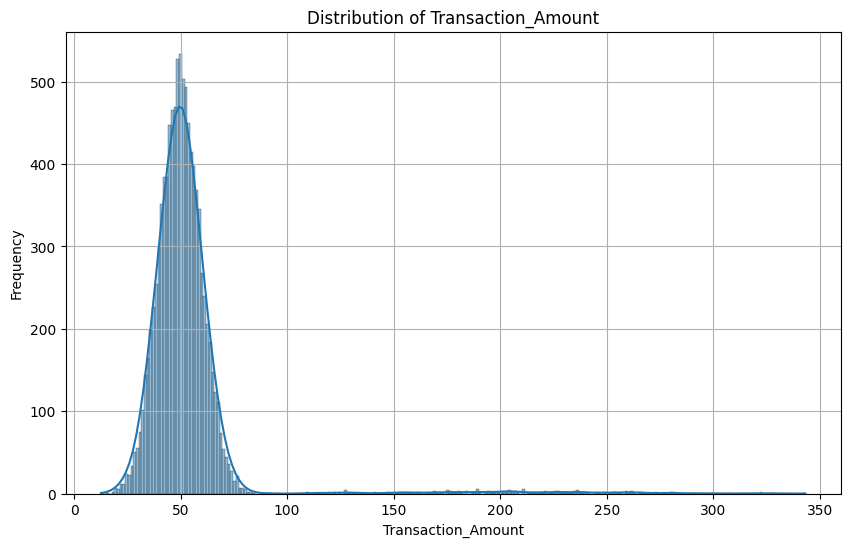

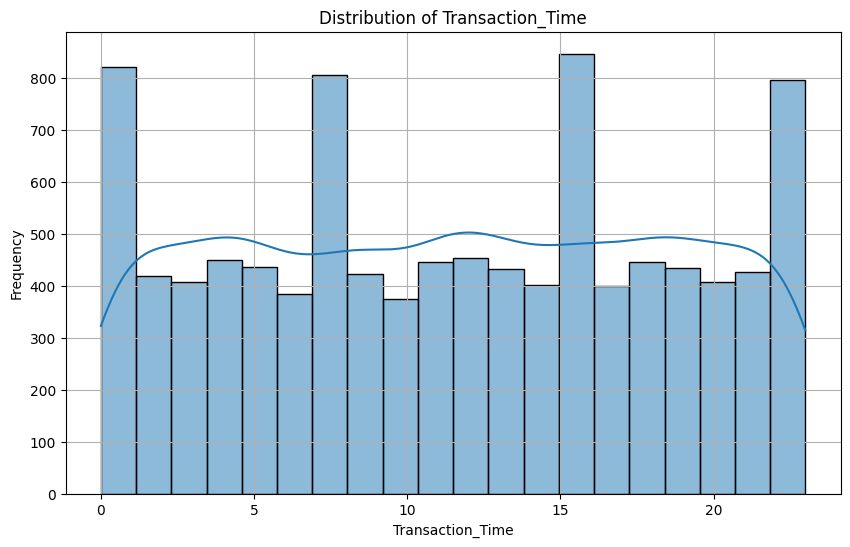

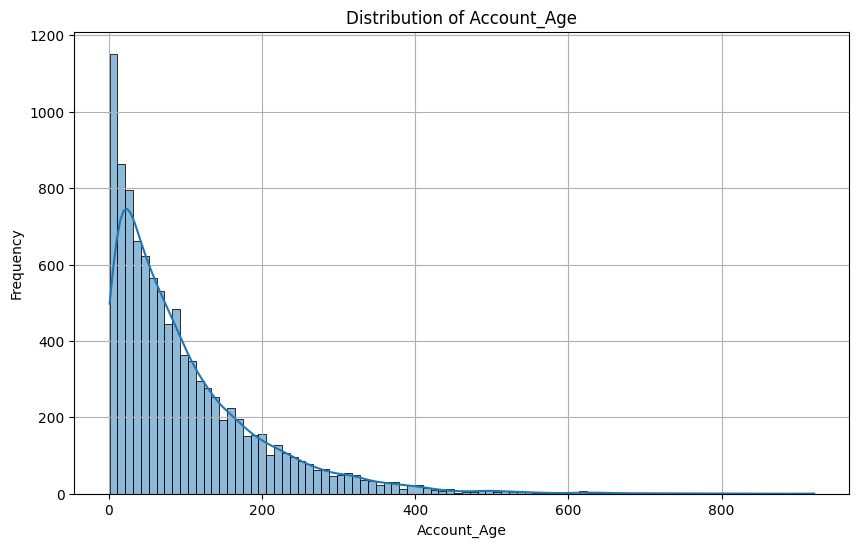

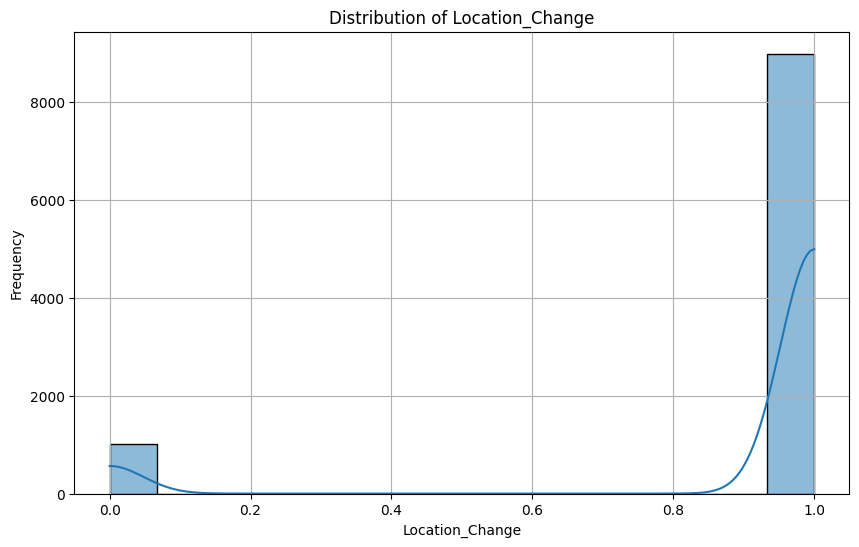

In [336]:
for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(primary_data[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [337]:
scalars = {}

for column in numerical_columns:
    if primary_data[column].skew() < 0.5: 
        print(f'{column} is normally distributed. Standardizing.')
        primary_data[column] = (primary_data[column] - primary_data[column].mean()) / primary_data[column].std()
        scalars[column] = {'mean': primary_data[column].mean(), 'std': primary_data[column].std(), 'method': 'standardization'}
    else:
        print(f'{column} is not normally distributed. Normalizing.')
        primary_data[column] = (primary_data[column] - primary_data[column].min()) / (primary_data[column].max() - primary_data[column].min())
        scalars[column] = {'min': primary_data[column].min(), 'max': primary_data[column].max(), 'method': 'normalization'}


Transaction_Amount is not normally distributed. Normalizing.
Transaction_Time is normally distributed. Standardizing.
Account_Age is not normally distributed. Normalizing.
Location_Change is normally distributed. Standardizing.


In [338]:
primary_data.describe()

,Transaction_Amount,Transaction_Time,Account_Age,Location_Change,Is_Fraud
count,10000.000000,1.000000e+04,10000.000000,1.000000e+04,10000.000000
mean,0.121827,-2.309264e-17,0.106429,8.242296e-17,0.020000
std,0.074973,1.000000e+00,0.107499,1.000000e+00,0.140007
min,0.000000,-1.668804e+00,0.000000,-2.973489e+00,0.000000
25%,0.092696,-9.436151e-01,0.028533,3.362717e-01,0.000000
50%,0.113011,7.164861e-02,0.073724,3.362717e-01,0.000000
75%,0.133987,9.418747e-01,0.148376,3.362717e-01,0.000000
max,1.000000,1.667063e+00,1.000000,3.362717e-01,1.000000


### Encoding Categorical Features

The only two categorical features are `Previous_Location` and `New_Location`. These are locations and could be as many unique values as there are rows in the dataframe, so using OneHot encoding, or even LabelEncoding would be very impractical and expensive. A better approach would be to create a word embedding for each city in the list.

Word vector embeddings are used to represent the `Previous_Location` and `New_Location` features in place of traditional one-hot encoding. Given that these columns could contain thousands of unique entries, one-hot encoding results in high-dimensional and sparse matrices, making it computationally expensive and potentially prone to overfitting. By using word embeddings, each unique location name is mapped to a dense, fixed-size vector that preserves semantic relationships between locations. This compact representation allows the model to capture nuanced similarities between locations, such as those that may be geographically close or frequently linked in transactions, which would be difficult to capture with one-hot encoding.

Using embeddings in this way helps reduce the complexity of the data while enhancing its expressiveness, supporting efficient training and potentially better predictive accuracy for fraud detection.

In [339]:
locations = set()

locations.update(primary_data['Previous_Location'].unique())
locations.update(primary_data['New_Location'].unique())

locations = list(locations)
locations

['Los Angeles',
 'Chicago',
 'San Jose',
 'Phoenix',
 'San Antonio',
 'Dallas',
 'Houston',
 'San Diego',
 'Philadelphia',
 'New York']

In [340]:
w2v_model = Word2Vec(sentences=[locations], vector_size=100, window=5, min_count=1, workers=4)
def get_embedding(location, model):
    return model.wv[location] if location in model.wv else np.zeros(model.vector_size)

In [341]:
primary_data['Previous_Location_Embed'] = primary_data['Previous_Location'].apply(lambda x: get_embedding(x, w2v_model))
primary_data['New_Location_Embed'] = primary_data['New_Location'].apply(lambda x: get_embedding(x, w2v_model))

In [342]:
primary_data

,Transaction_Amount,Transaction_Time,Account_Age,Previous_Location,New_Location,Location_Change,Is_Fraud,Previous_Location_Embed,New_Location_Embed
0,0.166459,0.071649,0.003577,New York,Houston,0.336272,0,"[-0.00053625664, 0.00023644432, 0.0051036295, ...","[-0.008242678, 0.009299355, -0.00019766092, -0..."
1,0.125211,0.651799,0.074885,Chicago,Phoenix,0.336272,0,"[-0.009579186, 0.008943655, 0.0041664126, 0.00...","[0.0081322715, -0.004457334, -0.0010683573, 0...."
2,0.142709,1.231950,0.076116,San Diego,Los Angeles,0.336272,0,"[9.456396e-05, 0.0030773198, -0.006812645, -0....","[-0.0051562428, -0.0066683376, -0.007776835, 0..."
3,0.180880,-1.523766,0.098554,Dallas,Philadelphia,0.336272,0,"[-0.007139015, 0.0012410306, -0.0071767163, -0...","[-0.0086196875, 0.003665738, 0.0051898835, 0.0..."
4,0.169589,-0.073389,0.017178,Dallas,Houston,0.336272,0,"[-0.007139015, 0.0012410306, -0.0071767163, -0...","[-0.008242678, 0.009299355, -0.00019766092, -0..."
...,...,...,...,...,...,...,...,...,...
9995,0.293161,-1.668804,0.026426,Phoenix,Houston,0.336272,1,"[0.0081322715, -0.004457334, -0.0010683573, 0....","[-0.008242678, 0.009299355, -0.00019766092, -0..."
9996,0.573151,1.231950,0.000456,New York,Phoenix,0.336272,1,"[-0.00053625664, 0.00023644432, 0.0051036295, ...","[0.0081322715, -0.004457334, -0.0010683573, 0...."
9997,0.644904,0.216686,0.020751,San Jose,San Antonio,0.336272,1,"[0.00816812, -0.0044430327, 0.008985434, 0.008...","[-0.0087274825, 0.0021301615, -0.0008735442, -..."
9998,0.561768,1.086912,0.024154,San Antonio,Houston,0.336272,1,"[-0.0087274825, 0.0021301615, -0.0008735442, -...","[-0.008242678, 0.009299355, -0.00019766092, -0..."


## Exploratory Data Analysis

To provide context to some of the visualisations seen later, below are ratios of the numbers of fraudelent and non-fraudulent transactions.

*Fraudenlent transactions (count):*

In [343]:
(primary_data['Is_Fraud'] == 1).sum()

200

As a ratio of the total number of transactions:

In [344]:
(primary_data['Is_Fraud'] == 1).sum()/len(primary_data) * 100

2.0

*Non-fraudenlent transactions (count):*

In [345]:
(primary_data['Is_Fraud'] == 0).sum()

9800

As a ratio of the total number of transactions:

In [346]:
(primary_data['Is_Fraud'] == 0).sum()/len(primary_data) * 100

98.0

The first set of relationships to be analysed is whether there appear to be relationships between each of the features, and whether a transaction was fraudulent or not.

### Relationships between Features and Is_Fraud

#### Transaction Amount vs Is_Fraud

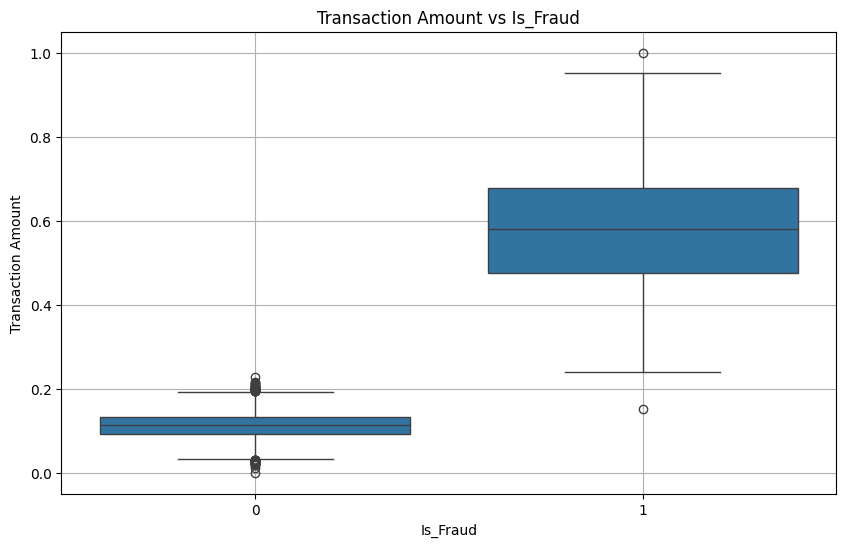

In [347]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Is_Fraud', y='Transaction_Amount', data=primary_data)
plt.title('Transaction Amount vs Is_Fraud')
plt.xlabel('Is_Fraud')
plt.ylabel('Transaction Amount')
plt.grid(True)
plt.show()

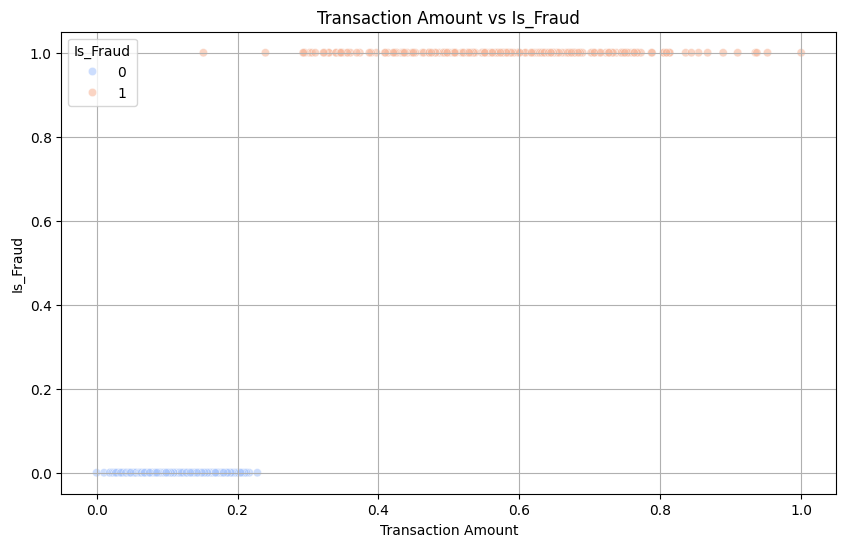

In [348]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Transaction_Amount', y='Is_Fraud', data=primary_data, hue='Is_Fraud', palette='coolwarm', alpha=0.6)
plt.title('Transaction Amount vs Is_Fraud')
plt.xlabel('Transaction Amount')
plt.ylabel('Is_Fraud')
plt.grid(True)
plt.show()

Almost all transactions that are fraudulent have a relatively higher transaction amount than those that are not fraudulent. This suggests that the transaction amount is a good indicator of whether a transaction is fraudulent or not.

#### Transaction Time vs Is_Fraud

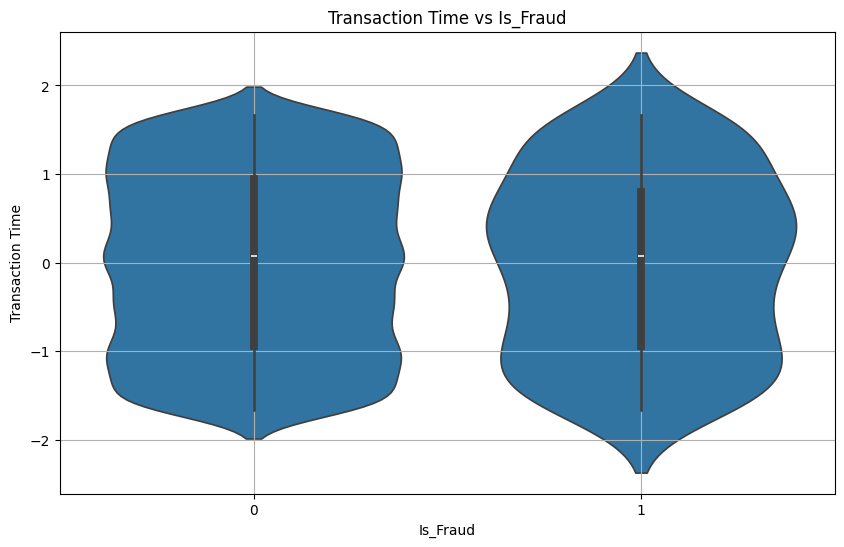

In [349]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Is_Fraud', y='Transaction_Time', data=primary_data)
plt.title('Transaction Time vs Is_Fraud')
plt.xlabel('Is_Fraud')
plt.ylabel('Transaction Time')
plt.grid(True)
plt.show()

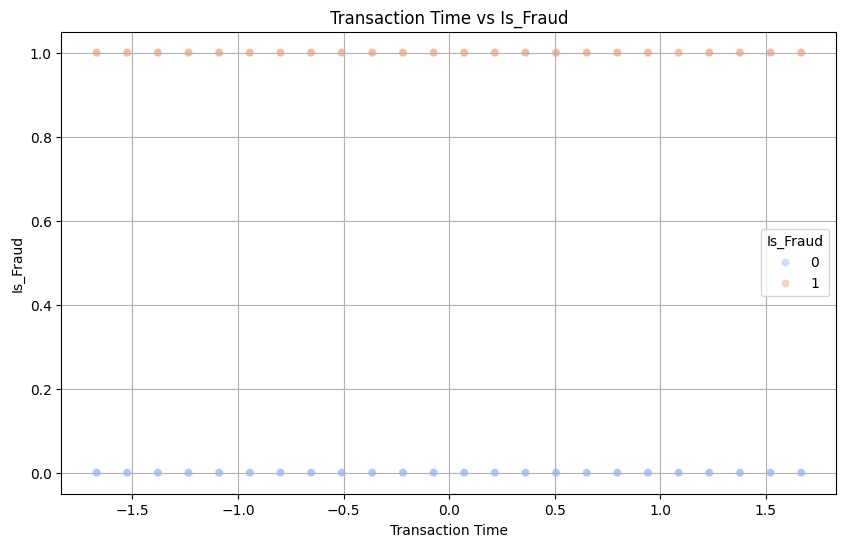

In [350]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Transaction_Time', y='Is_Fraud', data=primary_data, hue='Is_Fraud', palette='coolwarm', alpha=0.6)
plt.title('Transaction Time vs Is_Fraud')
plt.xlabel('Transaction Time')
plt.ylabel('Is_Fraud')
plt.grid(True)
plt.show()

For every hour, there seem to be equivalent numbers of fraudulent and non-fraudulent transactions. This suggests that the transaction time is not a good indicator of whether a transaction is fraudulent or not.

#### Account Age vs Is_Fraud

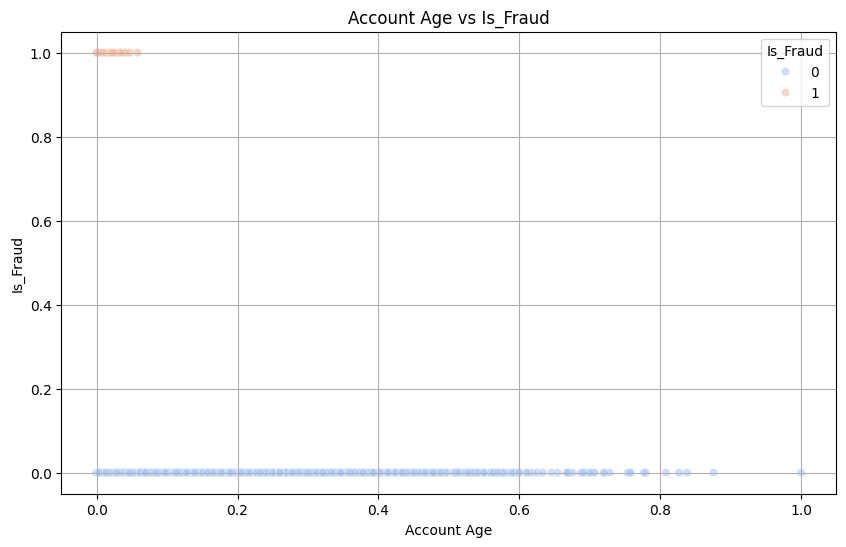

In [351]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Account_Age', y='Is_Fraud', data=primary_data, hue='Is_Fraud', palette='coolwarm', alpha=0.6)
plt.title('Account Age vs Is_Fraud')
plt.xlabel('Account Age')
plt.ylabel('Is_Fraud')
plt.grid(True)
plt.show()

All fraudulent transactions come from young accounts (the converse is not true). This is a strong indicator that account age is a highly correlated feature with fraudulent transactions.

#### misc

In [352]:
# previous_location_embeddings = np.vstack(primary_data['Previous_Location_Embed'].values)
# new_location_embeddings = np.vstack(primary_data['New_Location_Embed'].values)

# tsne = TSNE(n_components=2, random_state=42)
# previous_location_tsne = tsne.fit_transform(previous_location_embeddings)
# new_location_tsne = tsne.fit_transform(new_location_embeddings)

# previous_location_df = pd.DataFrame(previous_location_tsne, columns=['x', 'y'])
# previous_location_df['Is_Fraud'] = primary_data['Is_Fraud'].values

# new_location_df = pd.DataFrame(new_location_tsne, columns=['x', 'y'])
# new_location_df['Is_Fraud'] = primary_data['Is_Fraud'].values

#### Previous Location vs Is_Fraud

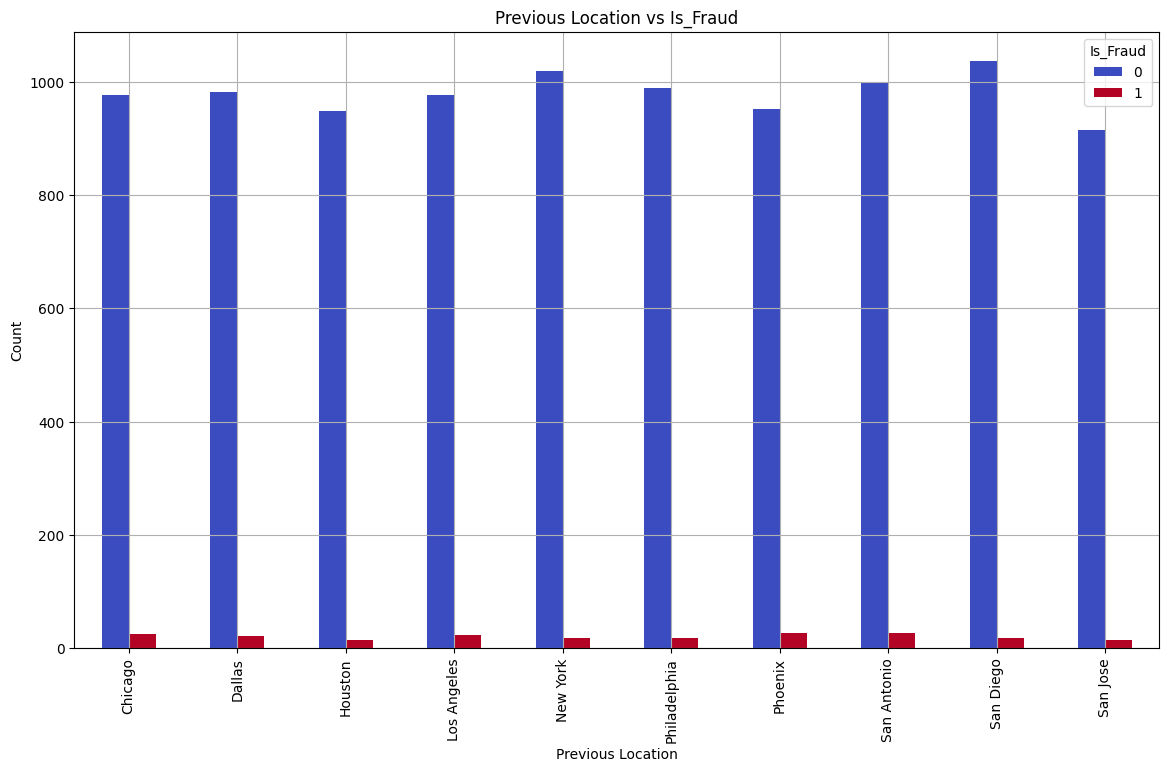

In [353]:
location_fraud_crosstab = pd.crosstab(primary_data['Previous_Location'], primary_data['Is_Fraud'])
location_fraud_crosstab.plot(kind='bar', figsize=(14, 8), colormap='coolwarm')
plt.title('Previous Location vs Is_Fraud')
plt.xlabel('Previous Location')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Is_Fraud')
plt.grid(True)
plt.show()

No region has a significantly higher number of fraudulent transactions than any of the other regions, so this is probably not a good feature for judging if a transaction is fraudulent.

#### New Location vs Is_Fraud

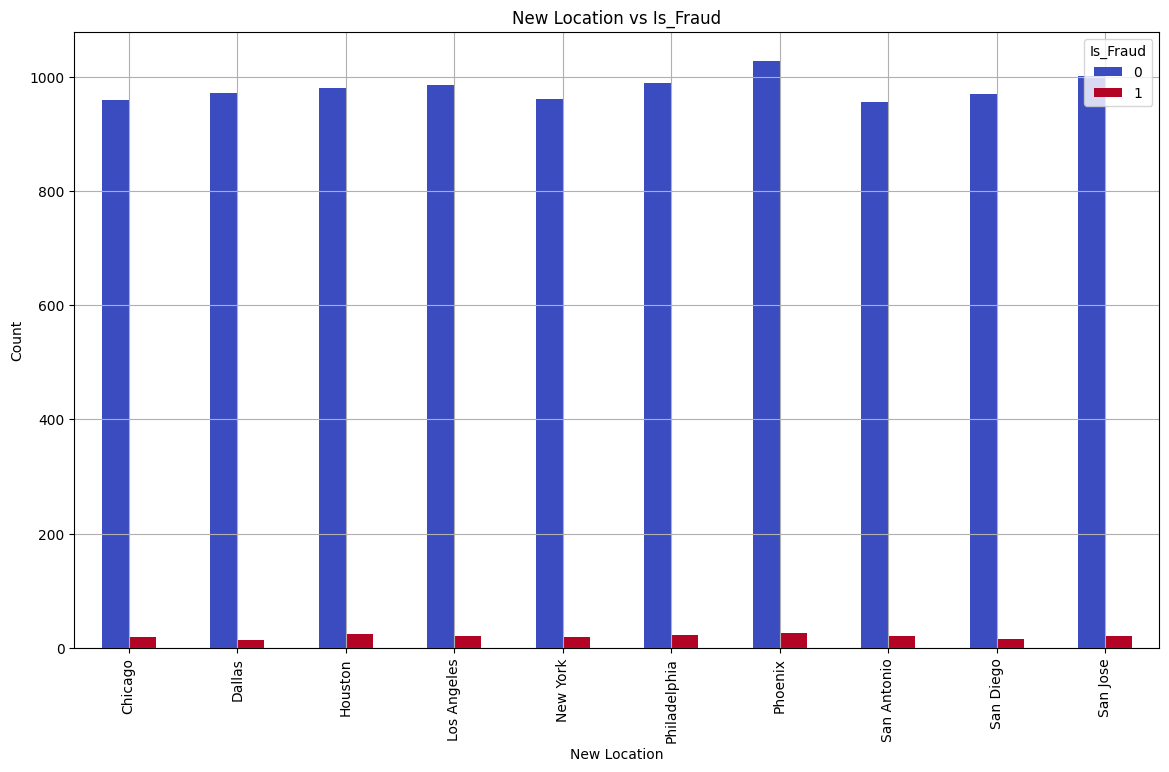

In [354]:
location_fraud_crosstab = pd.crosstab(primary_data['New_Location'], primary_data['Is_Fraud'])
location_fraud_crosstab.plot(kind='bar', figsize=(14, 8), colormap='coolwarm')
plt.title('New Location vs Is_Fraud')
plt.xlabel('New Location')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Is_Fraud')
plt.grid(True)
plt.show()

No region has a significantly higher number of fraudulent transactions than any of the other regions, so this is probably not a good feature for judging if a transaction is fraudulent.

#### Location Change vs Is_Fraud

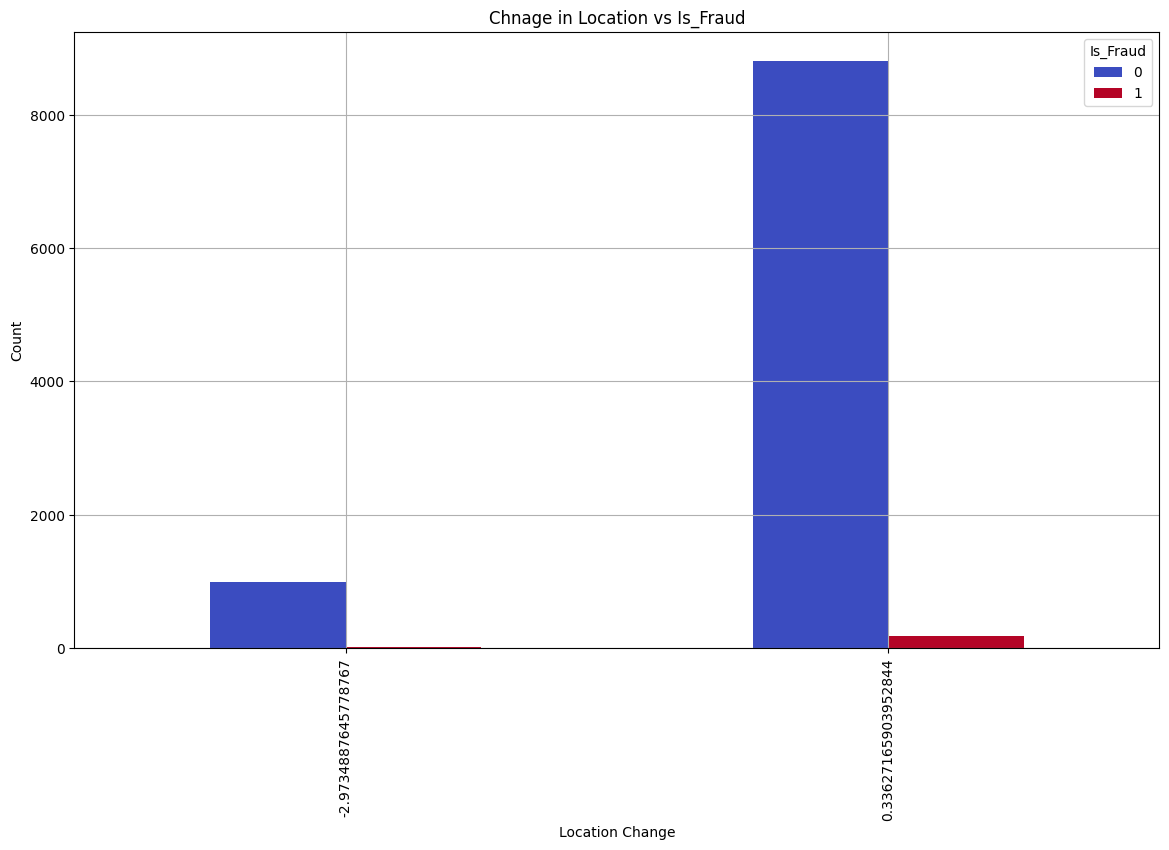

In [355]:
location_fraud_crosstab = pd.crosstab(primary_data['Location_Change'], primary_data['Is_Fraud'])
location_fraud_crosstab.plot(kind='bar', figsize=(14, 8), colormap='coolwarm')
plt.title('Chnage in Location vs Is_Fraud')
plt.xlabel('Location Change')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Is_Fraud')
plt.grid(True)
plt.show()

In [356]:
((primary_data['Location_Change'] < 0) & (primary_data['Is_Fraud'] == 1)).sum()

18

In [357]:
((primary_data['Location_Change'] < 0) & (primary_data['Is_Fraud'] == 0)).sum()

998

In [358]:
((primary_data['Location_Change'] > 0) & (primary_data['Is_Fraud'] == 1)).sum()

182

In [359]:
((primary_data['Location_Change'] > 0) & (primary_data['Is_Fraud'] == 0)).sum()

8802

An almost insignificant number of fraudulent transactions result from a transaction where the transaction was made from a location which was not the location where the card was issued (182/1000).

Tentatively, this feature is not a good predictor of fraudulent transactions.

### Correlation Analysis

To support my hypotheses about which features are good/bad predictors, I will use a correlation to find the highest correlated features.

In [360]:
primary_data.columns.to_list()

['Transaction_Amount',
 'Transaction_Time',
 'Account_Age',
 'Previous_Location',
 'New_Location',
 'Location_Change',
 'Is_Fraud',
 'Previous_Location_Embed',
 'New_Location_Embed']

In [361]:
locations = primary_data[['Previous_Location', 'New_Location']]

In [362]:
locations

,Previous_Location,New_Location
0,New York,Houston
1,Chicago,Phoenix
2,San Diego,Los Angeles
3,Dallas,Philadelphia
4,Dallas,Houston
...,...,...
9995,Phoenix,Houston
9996,New York,Phoenix
9997,San Jose,San Antonio
9998,San Antonio,Houston


In [363]:
numeric_columns = primary_data.select_dtypes(include=[float, int]).columns

corr_df = primary_data[numeric_columns].corr()

In [364]:
corr_df

,Transaction_Amount,Transaction_Time,Account_Age,Location_Change,Is_Fraud
Transaction_Amount,1.000000,0.000760,-0.114743,0.006506,0.871828
Transaction_Time,0.000760,1.000000,-0.014158,0.014551,-0.003647
Account_Age,-0.114743,-0.014158,1.000000,-0.003112,-0.128237
Location_Change,0.006506,0.014551,-0.003112,1.000000,0.005485
Is_Fraud,0.871828,-0.003647,-0.128237,0.005485,1.000000


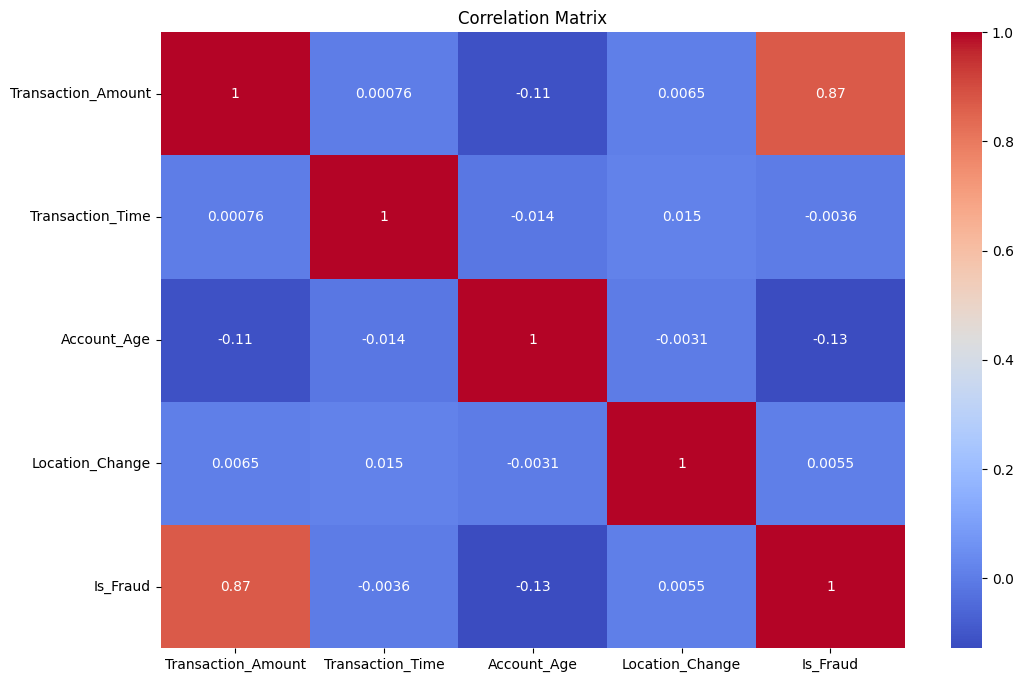

In [365]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Transaction amount is the highest correlated feature with `Is_Fraud` with a correlation of 0.87. This is followed by `Account_Age` with a correlation of -0.13. The other features have an absolute correlation of less than 0.001.

## Feature Engineering

Based on the relationships observed in the previous step, I will create new features that combine the most correlated features with `Is_Fraud`. I will also combine less correlated features to see if they can be used to predict `Is_Fraud`.

I will combine Location_Change and Transaction_Time (the 2 least correlated features) to see if together, their correlation with `Is_Fraud` is higher than their individual correlations.

In [366]:
primary_data['Time_And_Location'] = (primary_data['Transaction_Time'] * primary_data['Location_Change'])

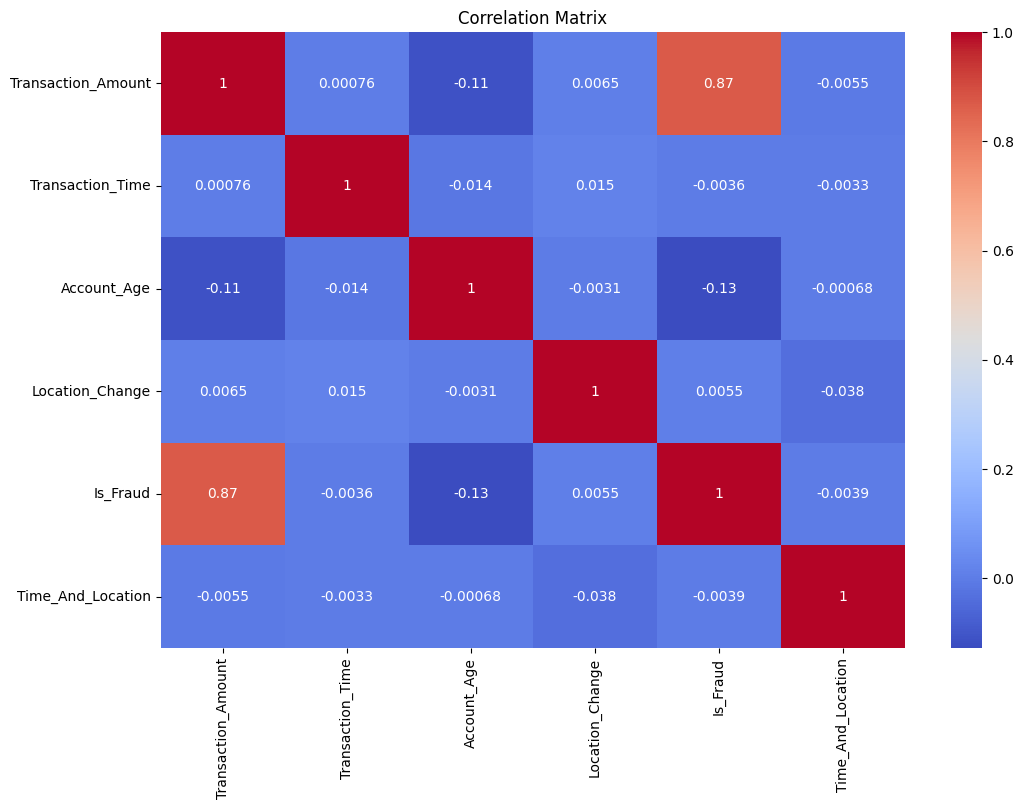

In [367]:
numeric_columns = primary_data.select_dtypes(include=[float, int]).columns

corr_df = primary_data[numeric_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [368]:
corr_df

,Transaction_Amount,Transaction_Time,Account_Age,Location_Change,Is_Fraud,Time_And_Location
Transaction_Amount,1.000000,0.000760,-0.114743,0.006506,0.871828,-0.005481
Transaction_Time,0.000760,1.000000,-0.014158,0.014551,-0.003647,-0.003343
Account_Age,-0.114743,-0.014158,1.000000,-0.003112,-0.128237,-0.000677
Location_Change,0.006506,0.014551,-0.003112,1.000000,0.005485,-0.038212
Is_Fraud,0.871828,-0.003647,-0.128237,0.005485,1.000000,-0.003937
Time_And_Location,-0.005481,-0.003343,-0.000677,-0.038212,-0.003937,1.000000


I will also combine Transaction_Amount and Account_Age to see if together, their correlation with `Is_Fraud` is higher than their individual correlations.

In [369]:
primary_data['Transaction_Amount_Acc_Age'] = primary_data['Transaction_Amount'] * -primary_data['Account_Age']

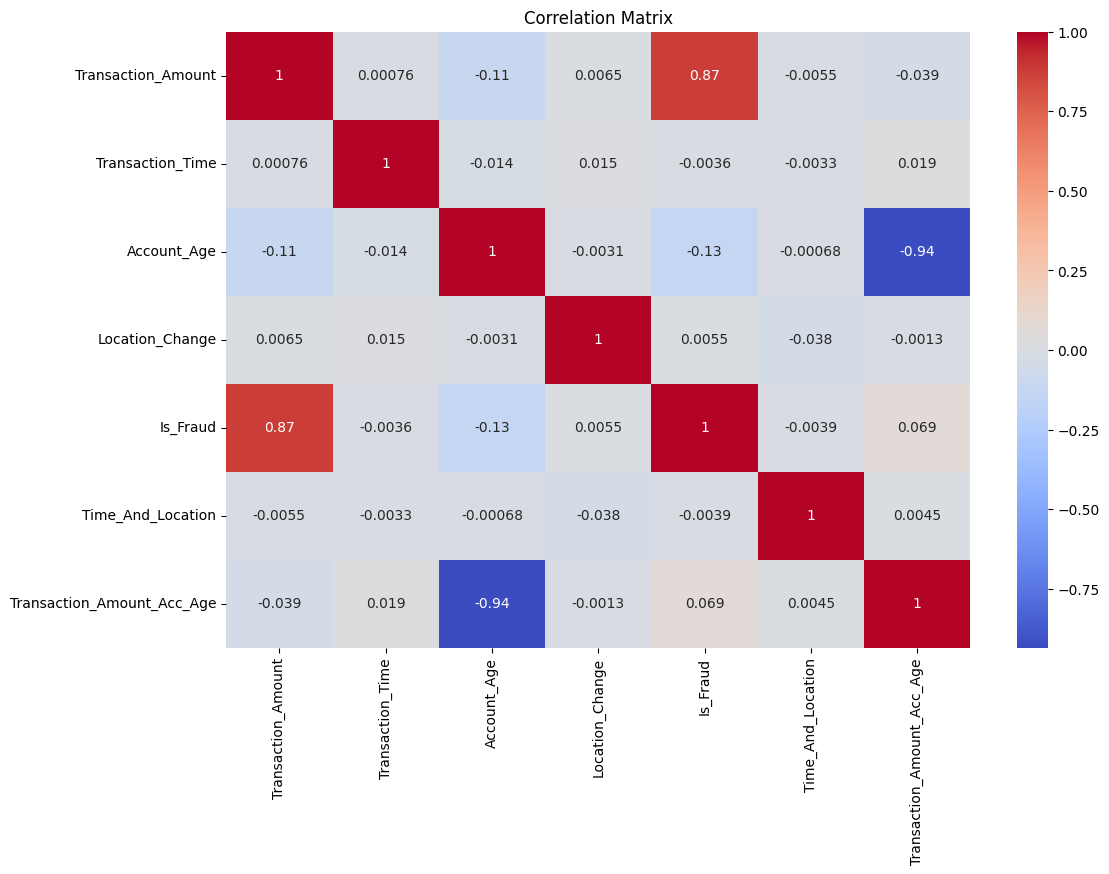

In [370]:
numeric_columns = primary_data.select_dtypes(include=[float, int]).columns

corr_df = primary_data[numeric_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [371]:
cols = primary_data[['Is_Fraud']]
primary_data.drop('Is_Fraud', axis=1, inplace=True)
primary_data = pd.concat([primary_data, cols], axis=1)
primary_data.head()

,Transaction_Amount,Transaction_Time,Account_Age,Previous_Location,New_Location,Location_Change,Previous_Location_Embed,New_Location_Embed,Time_And_Location,Transaction_Amount_Acc_Age,Is_Fraud
0,0.166459,0.071649,0.003577,New York,Houston,0.336272,"[-0.00053625664, 0.00023644432, 0.0051036295, ...","[-0.008242678, 0.009299355, -0.00019766092, -0...",0.024093,-0.000595,0
1,0.125211,0.651799,0.074885,Chicago,Phoenix,0.336272,"[-0.009579186, 0.008943655, 0.0041664126, 0.00...","[0.0081322715, -0.004457334, -0.0010683573, 0....",0.219182,-0.009376,0
2,0.142709,1.231950,0.076116,San Diego,Los Angeles,0.336272,"[9.456396e-05, 0.0030773198, -0.006812645, -0....","[-0.0051562428, -0.0066683376, -0.007776835, 0...",0.414270,-0.010862,0
3,0.180880,-1.523766,0.098554,Dallas,Philadelphia,0.336272,"[-0.007139015, 0.0012410306, -0.0071767163, -0...","[-0.0086196875, 0.003665738, 0.0051898835, 0.0...",-0.512399,-0.017826,0
4,0.169589,-0.073389,0.017178,Dallas,Houston,0.336272,"[-0.007139015, 0.0012410306, -0.0071767163, -0...","[-0.008242678, 0.009299355, -0.00019766092, -0...",-0.024679,-0.002913,0


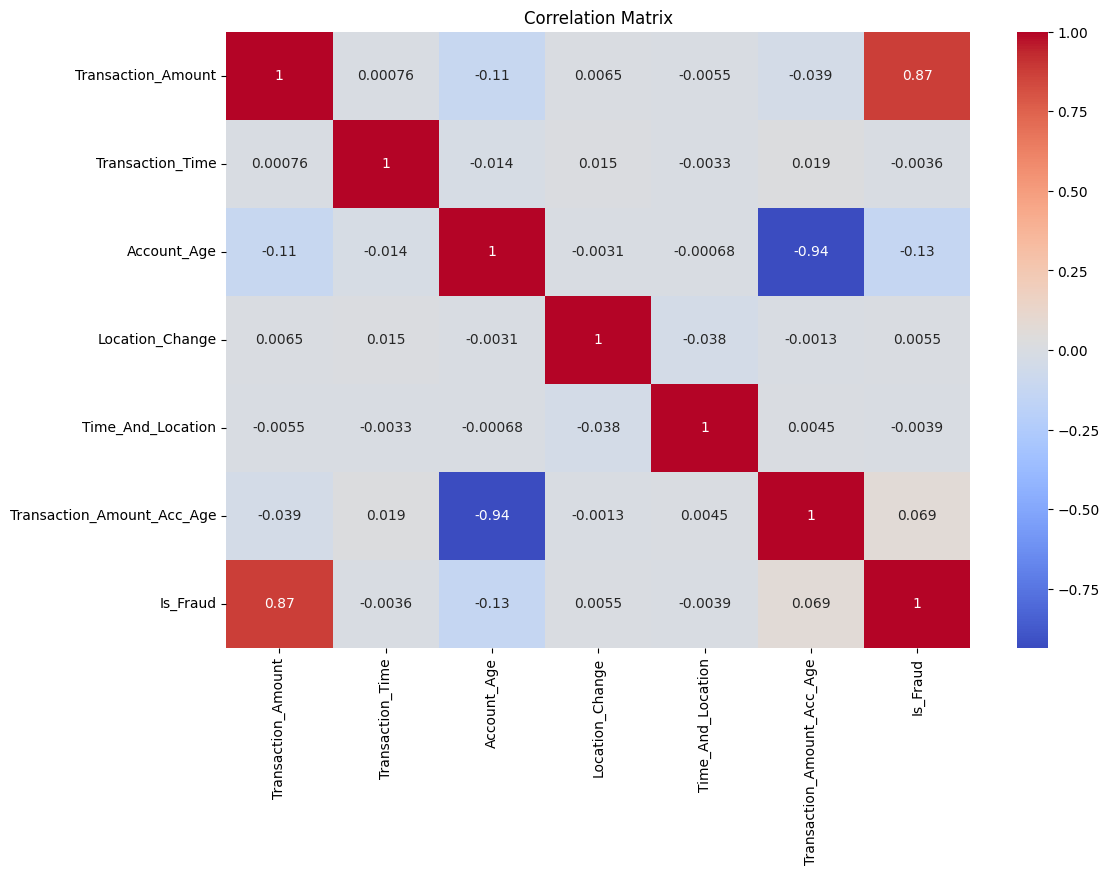

In [372]:
numeric_columns = primary_data.select_dtypes(include=[float, int]).columns

corr_df = primary_data[numeric_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

No feature created has a correlation with `Is_Fraud` greater than 0.87, the correlation of `Transaction_Amount` with `Is_Fraud`.

## Model Selection, Development, and Evaluation

In accordance with the constraints of the task, the models that will be used are Naive Bayes and Gaussian Discriminant Analysis. The models will be trained on the training data and evaluated on the testing data. The model with the best performance will be selected as the final model.

Even though there are only two models to choose from, the model selection process will involve hyperparameter tuning to ensure that the best model is selected.

There are strict requirements that a distribution must be normal for the Gaussian Discriminant Analysis model to be used. Additionally, the model requires that the covariance matrix of the features be the same for all classes. This is a strong assumption and may not hold true for the data. The Naive Bayes model does not have this requirement, and so it is likely that the Naive Bayes model will be the best model to use. However, the Naive Bayes model assumes that the features are independent, which may not be true for the data especially after the feature engineering step.

### Splitting the Data

I will split the data into training and testing sets using an 80/20 split. The training set will be used to train the models, and the testing set will be used to evaluate the models. The data will be split using the `train_test_split` function from the `sklearn.model_selection` module since there are no specific requirements to implement a custom split.

To ensure that the model developed is robust, I will use a KFold cross-validation with 5 folds to train the models. This will ensure that the model is trained on different subsets of the data and that the model is not overfitting the training data. This process is called cross-validation.

In [373]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

X = primary_data.select_dtypes(include=[float, int])

X = X.drop('Is_Fraud', axis=1)
y = primary_data['Is_Fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=92)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

### Model Training

I will be using a Gaussian Discriminant Analysis model and a Naive Bayes model to train the data. The models will be trained on the training data and evaluated on the testing data. The variant of the Naive Bayes model that will be used is the Gaussian Naive Bayes model because the features are continuous.

#### Gaussian Naive Bayes

In [374]:
nb = GaussianNB()
cv_scores = cross_val_score(nb, X_train, y_train, cv=kf, scoring='accuracy')

print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation score: {np.mean(cv_scores)}')

Cross-validation scores: [1.       1.       0.999375 1.       1.      ]
Mean cross-validation score: 0.9998750000000001


In [375]:
nb.fit(X_train, y_train)
test_score = nb.score(X_test, y_test)
print(f'Test score: {test_score}')

Test score: 0.9995


In [376]:
nb_test_preds = nb.predict(X_test)
nb_test_accuracy = accuracy_score(y_test, nb_test_preds)
nb_test_precision = precision_score(y_test, nb_test_preds)
nb_test_recall = recall_score(y_test, nb_test_preds)
nb_test_f1 = f1_score(y_test, nb_test_preds)
nb_test_confusion = confusion_matrix(y_test, nb_test_preds)
nb_test_classification = classification_report(y_test, nb_test_preds)

print(f'Accuracy: {nb_test_accuracy}')
print(f'Precision: {nb_test_precision}')
print(f'Recall: {nb_test_recall}')
print(f'F1 Score: {nb_test_f1}')
print(f'Confusion Matrix:\n{nb_test_confusion}')
print(f'Classification Report:\n{nb_test_classification}')

Accuracy: 0.9995
Precision: 1.0
Recall: 0.9714285714285714
F1 Score: 0.9855072463768115
Confusion Matrix:
[[1965    0]
 [   1   34]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1965
           1       1.00      0.97      0.99        35

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000



The model performs well on the training data with an accuracy of 0.99. The model also performs well on the testing data with an accuracy of 0.99.

#### Gaussian Discriminant Analysis

In [377]:
qda_model = QuadraticDiscriminantAnalysis()

In [378]:
qda_cv_scores = cross_val_score(qda_model, X_train, y_train, cv=kf, scoring='accuracy')

In [379]:
print(f'QDA Cross-validation scores: {qda_cv_scores}')
print(f'QDA Mean cross-validation score: {np.mean(qda_cv_scores)}')

QDA Cross-validation scores: [0.999375 0.99875  0.998125 0.99875  1.      ]
QDA Mean cross-validation score: 0.999


In [380]:
qda_model.fit(X_train, y_train)
qda_test_pred = qda_model.predict(X_test)

In [381]:
qda_test_accuracy = accuracy_score(y_test, qda_test_pred)
qda_test_precision = precision_score(y_test, qda_test_pred)
qda_test_recall = recall_score(y_test, qda_test_pred)
qda_test_f1 = f1_score(y_test, qda_test_pred)

In [382]:
print(f'QDA Test set accuracy: {qda_test_accuracy}')
print(f'QDA Test set precision: {qda_test_precision}')
print(f'QDA Test set recall: {qda_test_recall}')
print(f'QDA Test set F1-score: {qda_test_f1}')
print(confusion_matrix(y_test, qda_test_pred))
print(classification_report(y_test, qda_test_pred))

QDA Test set accuracy: 0.9985
QDA Test set precision: 0.9444444444444444
QDA Test set recall: 0.9714285714285714
QDA Test set F1-score: 0.9577464788732395
[[1963    2]
 [   1   34]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1965
           1       0.94      0.97      0.96        35

    accuracy                           1.00      2000
   macro avg       0.97      0.99      0.98      2000
weighted avg       1.00      1.00      1.00      2000



### Model Selection

Both models perform well on the training and testing data. The Gaussian Naive Bayes model has a slightly higher accuracy on the testing data than the Gaussian Discriminant Analysis model. The Gaussian Naive Bayes model will be selected as the final model.

## Hyperparameter Tuning

Ideally, the machine learning pipeline would involve hyperparameter tuning to ensure that the best model is selected. However, the Naive Bayes and GDA models are practically perfect and so hyperparameter tuning is not necessary. Any further tuning would likely result in overfitting the model to the training data.

## Feature Importance

The feature importance of the model will be analysed to determine which features are the most important in predicting whether a transaction is fraudulent or not. This will help in understanding the model and the task better. The simplest approach to this is to use a Random Forest model to determine the feature importance. This is because the Random Forest model is an ensemble model of decision trees, with each tree learning from a different subset of the data. The feature importance is calculated by averaging the importance of each feature across all the trees in the model.

In [383]:
rf_model = RandomForestClassifier(random_state=42)
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring='accuracy')
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Feature ranking:
1. feature 0 (0.8741943573976907)
2. feature 5 (0.06683112710891595)
3. feature 2 (0.054578515825453644)
4. feature 1 (0.0022057018828353166)
5. feature 4 (0.0020086067132743133)
6. feature 3 (0.0001816910718302114)


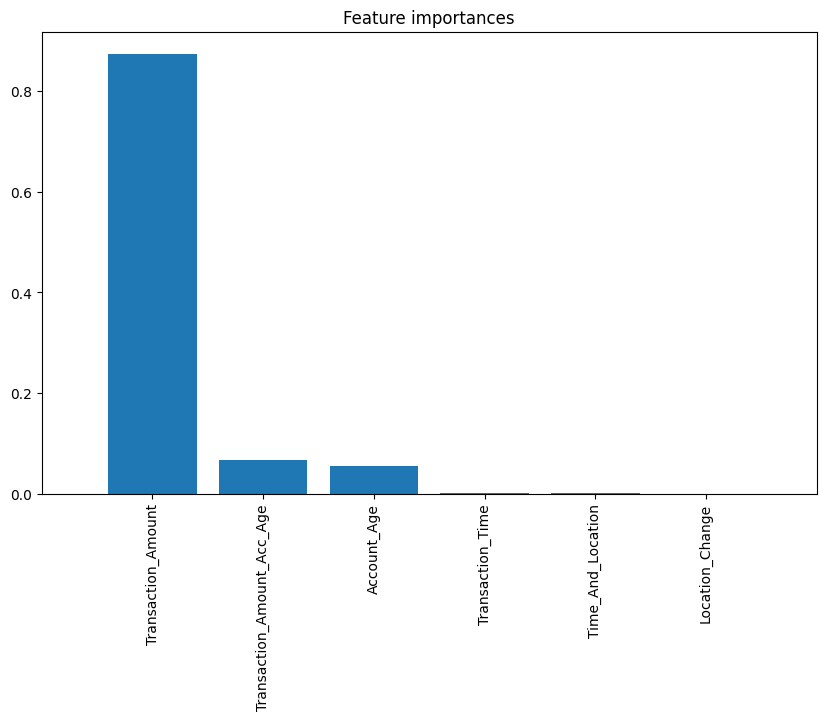

In [384]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X.shape[1]):
    print(f"{f + 1}. feature {indices[f]} ({importances[indices[f]]})")

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

Testing if the Naive Bayes model performs as well or better using just the most important features.

In [385]:
X_train_rf = X_train[['Transaction_Amount', 'Account_Age', 'Transaction_Amount_Acc_Age']]
X_test_rf = X_test[['Transaction_Amount', 'Account_Age', 'Transaction_Amount_Acc_Age']]

model = GaussianNB()
model.fit(X_train_rf, y_train)
test_preds = model.predict(X_test_rf)
test_accuracy = accuracy_score(y_test, test_preds)
test_precision = precision_score(y_test, test_preds)
test_recall = recall_score(y_test, test_preds)
test_f1 = f1_score(y_test, test_preds)
test_confusion = confusion_matrix(y_test, test_preds)
test_classification = classification_report(y_test, test_preds)


In [386]:
final_scalars = {}
for column in X_train_rf.columns:
    if column in scalars:
        final_scalars[column] = scalars[column]
final_scalars['scores'] = {'accuracy': test_accuracy, 'precision': test_precision, 'recall': test_recall, 'f1': test_f1}
        

In [387]:
print(f'Accuracy: {test_accuracy}')
print(f'Precision: {test_precision}')
print(f'Recall: {test_recall}')
print(f'F1 Score: {test_f1}')
print(f'Confusion Matrix:\n{test_confusion}')
print(f'Classification Report:\n{test_classification}')


Accuracy: 0.9995
Precision: 1.0
Recall: 0.9714285714285714
F1 Score: 0.9855072463768115
Confusion Matrix:
[[1965    0]
 [   1   34]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1965
           1       1.00      0.97      0.99        35

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000



The F1-score remains the same when using just the most important features. This suggests that the model is not overfitting the data and that the model is robust.

## Interpretation

### Most Important Features

According to the Random Forest model, the most important feature in predicting whether a transaction is fraudulent or not is the `Transaction_Amount` feature. This is followed by the engineered feature `Transaction_Amount_Account_Age` and the `Account_Age` feature. This tallies with the correlation analysis done earlier. It futher corroborates the hypotheses derived at the exploratory data analysis stage.

Intuitively, the transaction amount is a good indicator of whether a transaction is fraudulent or not. A large amount is more likely to be fraudulent than a small amount because a bad actor would want to maximise their gains. The account age is also a good indicator of whether a transaction is fraudulent or not. A new account is more likely to be fraudulent than an old account because a bad actor would want to maximise their gains before the account is closed. The engineered feature `Transaction_Amount_Account_Age` is a good indicator of whether a transaction is fraudulent or not because it combines the two most important features.

### Potential Biases (Overfitting)
The model may be overfitting the training data because the model has a high accuracy on the training data and a slightly (emphasis on slightly) lower accuracy on the testing data. This suggests that the model is memorising the training data instead of generalising to new data. This could be due to the model being too complex or the model being trained on too few data points. To reduce the likelihood of overfitting, the model could be trained on more data points or the model could be made less complex.

However, this could be attributed to the imbalance in the data. The model could be biased towards the majority class, which is the non-fraudulent transactions. This could be mitigated by using a different evaluation metric, such as the F1 score, which takes into account the precision and recall of the model (both models perform well on the F1 score).

### Improving the Model
With the current data, the model is performing well. However, there are a few ways that the model could be improved. The first way is to collect more data. More data would help the model generalise better to new data. The second way is to engineer more features. More features would help the model learn more complex patterns in the data. The third way is to use a different model. The Naive Bayes model is performing well, but there may be other models that perform better on the data. Even a simple model like logistic regression could be used to see if it performs better than the Naive Bayes model.

## Deployment

Intention was to deploy an application that would allow users to input the features of a transaction and get a prediction of whether the transaction is fraudulent or not. Ran out of time to do this.

In [388]:
import joblib
joblib.dump(model, 'model.joblib')
joblib.dump(final_scalars, 'scalars.joblib')

['scalars.joblib']

These changes were retroactively implemented in the code:
- After scaling, the scalars (min, max, mean, std) were stored in a dictionary for use in the deployment phase.
- The model was saved using the `joblib` library.
- The scalars were saved using the `joblib` library.